# ResNet18 implementation

ResNet paper:
https://arxiv.org/pdf/1512.03385.pdf

The implementation details of ResNet18 are listed in Table 1 of the paper.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

In [2]:
class ResidualBlock18(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(ResidualBlock18, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.batchnorm1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(out_channels)

    self.identity_mapping = None
    if stride != 1 or in_channels != out_channels:
      self.identity_mapping = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    identity = x

    c1 = self.conv1(x)
    bn1 = self.batchnorm1(c1)
    a1 = nn.functional.relu(bn1)

    c2 = self.conv2(a1)
    bn2 = self.batchnorm2(c2)

    if self.identity_mapping is not None:
      identity = self.identity_mapping(x)

    bn2 += identity
    out = nn.functional.relu(bn2)

    return out

In [3]:
class ResNet18(nn.Module):
  def __init__(self, img_channels, num_classes):
    super(ResNet18, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    self.batchnorm = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.resblock1 = nn.Sequential(
      ResidualBlock18(in_channels=64, out_channels=64, stride=1),
      ResidualBlock18(in_channels=64, out_channels=64, stride=1)
    )
    self.resblock2 = nn.Sequential(
      ResidualBlock18(in_channels=64, out_channels=128, stride=2),
      ResidualBlock18(in_channels=128, out_channels=128, stride=1)
    )
    self.resblock3 = nn.Sequential(
      ResidualBlock18(in_channels=128, out_channels=256, stride=2),
      ResidualBlock18(in_channels=256, out_channels=256, stride=1)
    )
    self.resblock4 = nn.Sequential(
      ResidualBlock18(in_channels=256, out_channels=512, stride=2),
      ResidualBlock18(in_channels=512, out_channels=512, stride=1)
    )

    self.pool2 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.fc_out = nn.Linear(512, num_classes)

    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
      elif isinstance(module, nn.BatchNorm2d):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)


  def forward(self, x):
    c1 = self.conv1(x)
    bn1 = self.batchnorm(c1)
    a1 = nn.functional.relu(bn1)
    p1 = self.pool1(a1)

    rb1 = self.resblock1(p1)
    rb2 = self.resblock2(rb1)
    rb3 = self.resblock3(rb2)
    rb4 = self.resblock4(rb3)

    p2 = self.pool2(rb4)
    p2 = torch.flatten(p2, 1)
    out = self.fc_out(p2)

    return out

# Loading the data

We will use a bird dataset, where the task is to classify each image into one of 400 different classes of birds.

## Download the data

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown  --id 1ZjdZigcUnMxT_KG5P0GVolQ9y-7wgZM1
!unzip -q bird_data.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZjdZigcUnMxT_KG5P0GVolQ9y-7wgZM1
From (redirected): https://drive.google.com/uc?id=1ZjdZigcUnMxT_KG5P0GVolQ9y-7wgZM1&confirm=t&uuid=ebeb9ad2-4a48-4120-a428-54a69cf40751
To: /content/bird_data.zip
100% 1.40G/1.40G [00:25<00:00, 54.2MB/s]


## Data Loader

* PyTorch typically uses Dataset and DataLoader classes to load data during training. The DataLoader enables processing data on multiple cores (num_workers argument), which is useful as the data loading speed is commonly the bottleneck in network training.

* The batch size used during training is also usually an argument of the DataLoader.

* We will be using the torchvision.datasets.ImageFolder class that can easily load images that have been separated into individual folders by class. The data loader then outputs the data in the form of (image, label) pairs. For tasks other than classification, custom dataset classes are more common.

images-size: torch.Size([128, 3, 224, 224])


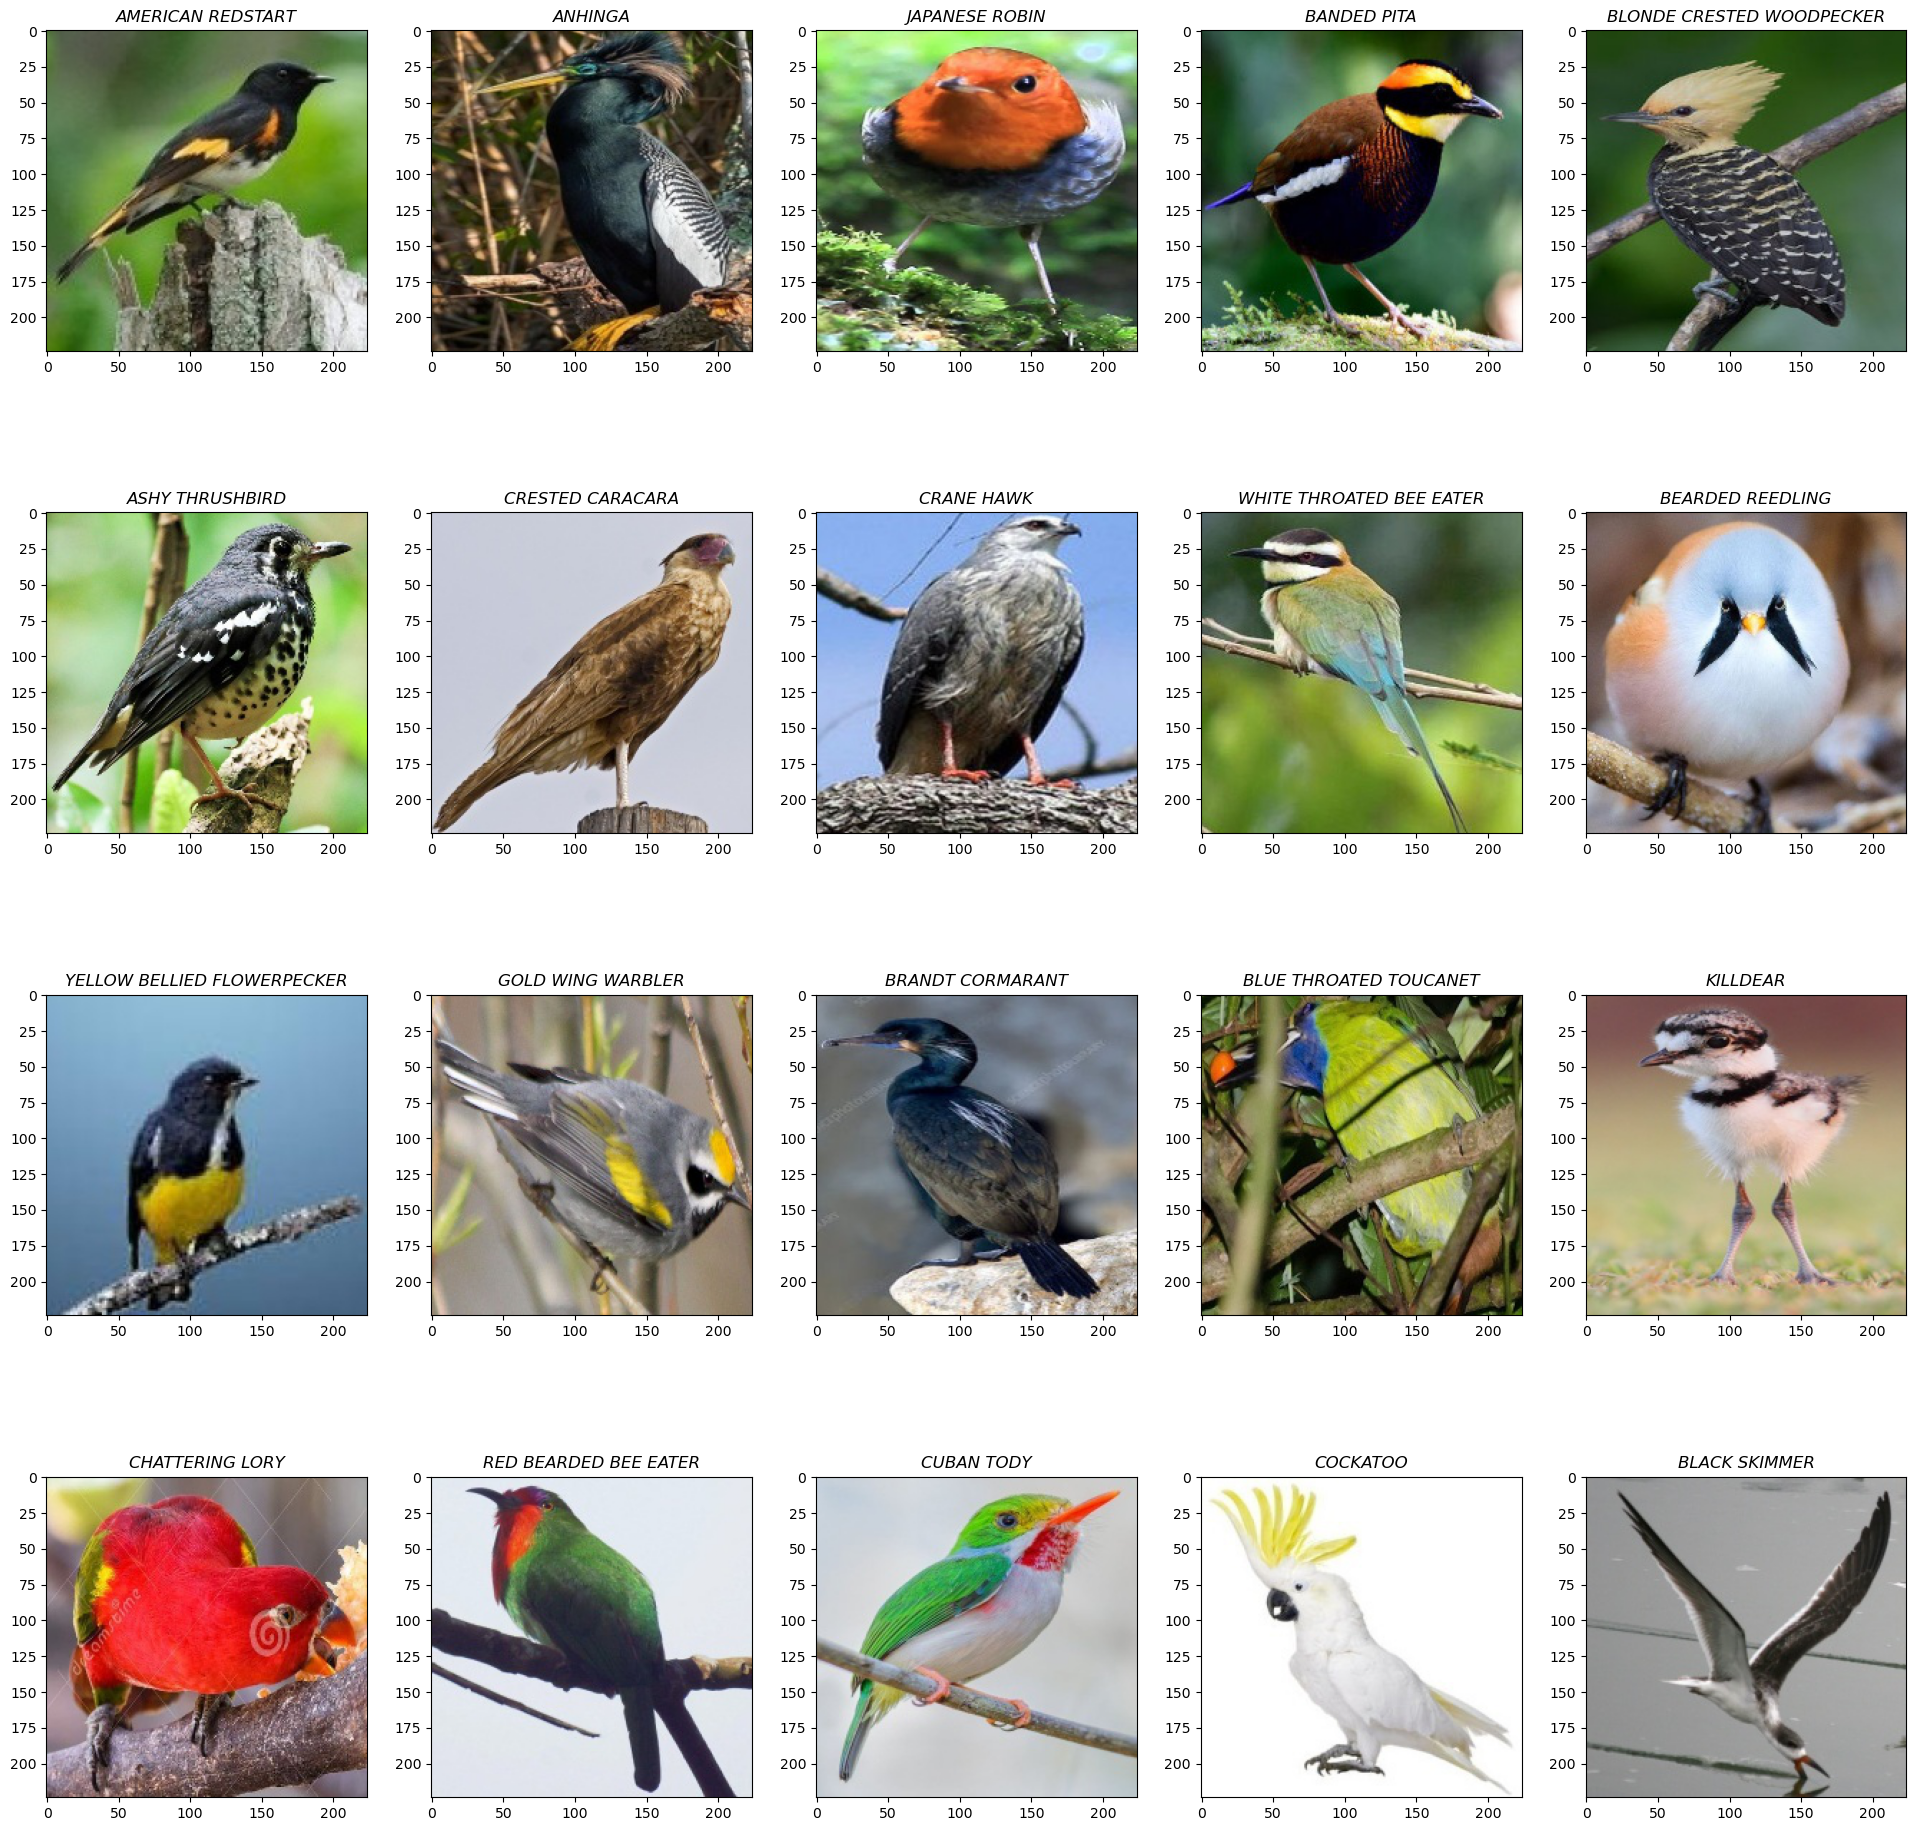

In [4]:
batch_size = 128
transform = transforms.Compose(
  [
    transforms.ToTensor()
  ]
)

trainset = torchvision.datasets.ImageFolder(root='./data/bird_data/train/', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root='./data/bird_data/test/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

valset = torchvision.datasets.ImageFolder(root='./data/bird_data/valid/', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

images, labels = next(iter(trainloader))
print("images-size:", images.shape)

# Displaying random trainset images
fig=plt.figure(figsize=(24, 24))
columns = 5
rows = 4
for i in range(columns*rows):
  input, label = trainset[np.random.randint(len(trainset))]
  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  ax.set_title(trainset.classes[label], fontstyle='italic')
  plt.imshow(img)
plt.show()

## Training the network

The training parameters (learning rate, batch size, optimizer choice etc.) are not fine-tuned. Feel free to optimize the parameters further to improve the results.

In [5]:
def train(model, dataloader, optimizer, criterion, epoch, epochs):
  model.train()
  train_loss = 0.0
  train_correct = 0
  total = 0
  total_step = len(dataloader)
  with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch+1)+"/"+str(epochs), unit='img') as prog_bar:
    for i, data in enumerate(dataloader, 0):
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()

      loss.backward()
      optimizer.step()

      outputs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(outputs.data, 1)
      train_correct += torch.sum(preds == labels).item()

      total += labels.size(0)
      prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
      prog_bar.update(labels.size(0))

  epoch_loss = train_loss / total_step
  epoch_acc = 100 * (train_correct / total)

  return epoch_loss, epoch_acc

In [6]:
def validate(model, dataloader, criterion):
  model.eval()
  num_images = len(dataloader.dataset)
  val_loss = 0.0
  val_correct = 0
  total = 0
  total_step = len(dataloader)
  gt_array = np.zeros(num_images)
  pred_array = np.zeros(num_images)

  with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader), total=total_step):
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      outputs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(outputs.data, 1)
      val_correct += (preds == labels).sum().item()
      total += labels.size(0)
      gt_array[i*labels.size(0):(i+1)*labels.size(0)] = labels.detach().cpu().numpy()
      pred_array[i*labels.size(0):(i+1)*labels.size(0)] = preds.detach().cpu().numpy()

  epoch_loss = val_loss / total_step
  epoch_acc = 100 * val_correct / total

  return gt_array, pred_array, epoch_loss, epoch_acc

In [7]:
def train_bird_model(epochs, lr, lambda_reg, optim_type="adam"):
  net = ResNet18(img_channels=trainset[0][0].shape[0], num_classes=len(trainset.classes))
  net.cuda()

  # Define the loss function
  criterion = nn.CrossEntropyLoss()

  # Initialize the optimizer
  if optim_type == "adam":
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=lambda_reg)
  else:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=lambda_reg)

  val_loss_min = np.Inf
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  best_net = None
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

  for epoch in range(epochs):
    train_loss_curr, train_acc_curr = train(net, trainloader, optimizer, criterion, epoch, epochs)
    train_acc.append(train_acc_curr)
    train_loss.append(train_loss_curr)
    print(f'\ntraining loss: {train_loss_curr:.4f}, training accuracy: {train_acc_curr:.2f} %')

    _, _, val_loss_curr, val_acc_curr = validate(net, valloader, criterion)
    val_acc.append(val_acc_curr)
    val_loss.append(val_loss_curr)
    print(f'validation loss: {val_loss_curr:.4f}, validation accuracy: {val_acc_curr:.2f} %\n')
    scheduler.step(val_loss_curr)

    scheduler.step(val_loss_curr)

    improvement = val_loss_curr < val_loss_min
    if improvement:
      val_loss_min = val_loss_curr
      best_net = net
      print("IMPROVEMENT")

  return train_loss, train_acc, val_loss, val_acc, best_net

## Run training

In [ ]:
# Results for batch size 64
# train_loss, train_acc, val_loss, val_acc, net = train_bird_model(
#   epochs=20,
#   lr=0.01,
#   lambda_reg=0.0,
#   optim_type="sgd"
# )

Epoch: 1/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:18<00:00, 294.49img/s, loss=3.1267867]



training loss: 4.6202, training accuracy: 9.45 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.29it/s]


validation loss: 3.4164, validation accuracy: 23.55 %

IMPROVEMENT


Epoch: 2/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:18<00:00, 294.56img/s, loss=2.7220829]



training loss: 2.7384, training accuracy: 36.56 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.20it/s]


validation loss: 2.0432, validation accuracy: 49.75 %

IMPROVEMENT


Epoch: 3/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.91img/s, loss=1.1642525]



training loss: 1.8048, training accuracy: 56.01 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.92it/s]


validation loss: 1.3715, validation accuracy: 63.15 %

IMPROVEMENT


Epoch: 4/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.22img/s, loss=1.5312064]



training loss: 1.3102, training accuracy: 67.39 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.05it/s]


validation loss: 1.0914, validation accuracy: 71.30 %

IMPROVEMENT


Epoch: 5/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.93img/s, loss=1.6432613]



training loss: 1.0031, training accuracy: 74.50 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.92it/s]


validation loss: 0.9521, validation accuracy: 74.45 %

IMPROVEMENT


Epoch: 6/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.89img/s, loss=0.5240066]



training loss: 0.7769, training accuracy: 79.86 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.02it/s]


validation loss: 0.9360, validation accuracy: 75.20 %

IMPROVEMENT


Epoch: 7/20: 100%|████████████████████████████████████████████| 58388/58388 [03:23<00:00, 287.60img/s, loss=0.42483872]



training loss: 0.6058, training accuracy: 84.00 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.97it/s]


validation loss: 0.7649, validation accuracy: 79.85 %

IMPROVEMENT


Epoch: 8/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:24<00:00, 284.93img/s, loss=0.6331132]



training loss: 0.4596, training accuracy: 87.69 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.79it/s]


validation loss: 0.6851, validation accuracy: 81.40 %

IMPROVEMENT


Epoch: 9/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:26<00:00, 283.18img/s, loss=0.3489416]



training loss: 0.3286, training accuracy: 91.45 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.13it/s]


validation loss: 0.6342, validation accuracy: 83.60 %

IMPROVEMENT


Epoch: 10/20: 100%|████████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.89img/s, loss=0.2870968]



training loss: 0.2192, training accuracy: 94.50 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.74it/s]


validation loss: 0.7438, validation accuracy: 80.15 %



Epoch: 11/20: 100%|███████████████████████████████████████████| 58388/58388 [03:20<00:00, 291.64img/s, loss=0.10711839]



training loss: 0.1346, training accuracy: 96.87 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.90it/s]


validation loss: 0.5751, validation accuracy: 84.25 %

IMPROVEMENT


Epoch: 12/20: 100%|███████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.73img/s, loss=0.11392088]



training loss: 0.0694, training accuracy: 98.75 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.92it/s]


validation loss: 0.4552, validation accuracy: 88.00 %

IMPROVEMENT


Epoch: 13/20: 100%|███████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.84img/s, loss=0.06424168]



training loss: 0.0322, training accuracy: 99.67 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.19it/s]


validation loss: 0.3689, validation accuracy: 90.40 %

IMPROVEMENT


Epoch: 14/20: 100%|██████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.27img/s, loss=0.014590107]



training loss: 0.0165, training accuracy: 99.90 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.03it/s]


validation loss: 0.3313, validation accuracy: 91.30 %

IMPROVEMENT


Epoch: 15/20: 100%|██████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.80img/s, loss=0.017788175]



training loss: 0.0093, training accuracy: 99.98 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.40it/s]


validation loss: 0.2985, validation accuracy: 92.10 %

IMPROVEMENT


Epoch: 16/20: 100%|██████████████████████████████████████████| 58388/58388 [03:18<00:00, 293.81img/s, loss=0.052134573]



training loss: 0.0072, training accuracy: 99.98 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.20it/s]


validation loss: 0.3142, validation accuracy: 92.10 %



Epoch: 17/20: 100%|██████████████████████████████████████████| 58388/58388 [03:19<00:00, 291.95img/s, loss=0.011692029]



training loss: 0.0061, training accuracy: 99.98 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.79it/s]


validation loss: 0.3090, validation accuracy: 91.85 %



Epoch: 18/20: 100%|██████████████████████████████████████████| 58388/58388 [03:18<00:00, 294.25img/s, loss=0.046689946]



training loss: 0.0047, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.24it/s]


validation loss: 0.3039, validation accuracy: 92.15 %



Epoch: 19/20: 100%|██████████████████████████████████████████| 58388/58388 [03:18<00:00, 293.69img/s, loss=0.018050041]



training loss: 0.0040, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.96it/s]


validation loss: 0.3012, validation accuracy: 92.20 %



Epoch: 20/20: 100%|██████████████████████████████████████████| 58388/58388 [03:18<00:00, 294.35img/s, loss=0.029721033]



training loss: 0.0036, training accuracy: 100.00 %


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.08it/s]

validation loss: 0.3050, validation accuracy: 92.20 %



In [ ]:
# Results for batch size 128
# train_loss, train_acc, val_loss, val_acc, net = train_bird_model(
#   epochs=20,
#   lr=0.1,
#   lambda_reg=0.0,
#   optim_type="sgd"
# )

Epoch: 1/20: 100%|██████████████████████████████████████████████| 58388/58388 [03:14<00:00, 299.89img/s, loss=3.817226]



training loss: 4.5719, training accuracy: 9.97 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


validation loss: 3.7905, validation accuracy: 16.95 %

IMPROVEMENT


Epoch: 2/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:53<00:00, 250.06img/s, loss=1.5769656]



training loss: 2.4879, training accuracy: 41.01 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


validation loss: 1.9723, validation accuracy: 50.55 %

IMPROVEMENT


Epoch: 3/20: 100%|█████████████████████████████████████████████| 58388/58388 [07:42<00:00, 126.25img/s, loss=1.1532718]



training loss: 1.5340, training accuracy: 61.62 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


validation loss: 1.2099, validation accuracy: 68.95 %

IMPROVEMENT


Epoch: 4/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.79img/s, loss=0.9746706]



training loss: 1.0567, training accuracy: 72.63 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s]


validation loss: 0.8540, validation accuracy: 75.70 %

IMPROVEMENT


Epoch: 5/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:21<00:00, 290.44img/s, loss=0.7764891]



training loss: 0.7583, training accuracy: 79.77 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


validation loss: 0.8568, validation accuracy: 77.35 %



Epoch: 6/20: 100%|████████████████████████████████████████████| 58388/58388 [03:23<00:00, 286.78img/s, loss=0.43606314]



training loss: 0.5372, training accuracy: 85.39 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


validation loss: 0.7148, validation accuracy: 79.35 %

IMPROVEMENT


Epoch: 7/20: 100%|████████████████████████████████████████████| 58388/58388 [03:24<00:00, 286.09img/s, loss=0.24765691]



training loss: 0.3597, training accuracy: 89.98 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


validation loss: 0.6022, validation accuracy: 82.95 %

IMPROVEMENT


Epoch: 8/20: 100%|███████████████████████████████████████████| 58388/58388 [03:24<00:00, 284.89img/s, loss=0.041414604]



training loss: 0.2249, training accuracy: 93.70 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


validation loss: 0.7029, validation accuracy: 81.00 %



Epoch: 9/20: 100%|████████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.21img/s, loss=0.23724659]



training loss: 0.1176, training accuracy: 96.83 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.96it/s]


validation loss: 0.5508, validation accuracy: 86.15 %

IMPROVEMENT


Epoch: 10/20: 100%|███████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.25img/s, loss=0.15627769]



training loss: 0.0570, training accuracy: 98.72 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


validation loss: 0.4671, validation accuracy: 87.70 %

IMPROVEMENT


Epoch: 11/20: 100%|███████████████████████████████████████████| 58388/58388 [03:26<00:00, 282.42img/s, loss=0.14322379]



training loss: 0.0283, training accuracy: 99.43 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


validation loss: 0.3859, validation accuracy: 89.95 %

IMPROVEMENT


Epoch: 12/20: 100%|████████████████████████████████████████████| 58388/58388 [03:25<00:00, 284.74img/s, loss=0.1459361]



training loss: 0.0162, training accuracy: 99.73 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.98it/s]


validation loss: 0.3325, validation accuracy: 91.05 %

IMPROVEMENT


Epoch: 13/20: 100%|███████████████████████████████████████████| 58388/58388 [03:27<00:00, 281.86img/s, loss=0.40921006]



training loss: 0.0159, training accuracy: 99.75 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


validation loss: 0.3200, validation accuracy: 91.45 %

IMPROVEMENT


Epoch: 14/20: 100%|██████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.81img/s, loss=0.019410463]



training loss: 0.0081, training accuracy: 99.90 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.68it/s]


validation loss: 0.3234, validation accuracy: 91.30 %



Epoch: 15/20: 100%|██████████████████████████████████████████| 58388/58388 [03:21<00:00, 290.36img/s, loss=0.018410357]



training loss: 0.0031, training accuracy: 99.97 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s]


validation loss: 0.2985, validation accuracy: 92.30 %

IMPROVEMENT


Epoch: 16/20: 100%|█████████████████████████████████████████| 58388/58388 [03:23<00:00, 286.61img/s, loss=0.0027966122]



training loss: 0.0018, training accuracy: 99.98 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


validation loss: 0.2888, validation accuracy: 92.45 %

IMPROVEMENT


Epoch: 17/20: 100%|█████████████████████████████████████████| 58388/58388 [03:25<00:00, 283.63img/s, loss=0.0011669145]



training loss: 0.0013, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


validation loss: 0.2847, validation accuracy: 91.90 %

IMPROVEMENT


Epoch: 18/20: 100%|██████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.98img/s, loss=0.049169607]



training loss: 0.0011, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


validation loss: 0.2932, validation accuracy: 92.00 %



Epoch: 19/20: 100%|██████████████████████████████████████████| 58388/58388 [03:24<00:00, 284.93img/s, loss=0.011959096]



training loss: 0.0031, training accuracy: 99.96 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


validation loss: 0.3090, validation accuracy: 92.35 %



Epoch: 20/20: 100%|██████████████████████████████████████████| 58388/58388 [03:25<00:00, 284.52img/s, loss=0.003672627]



training loss: 0.0010, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s]

validation loss: 0.3028, validation accuracy: 92.40 %



In [ ]:
# Results for batch size 256
# train_loss, train_acc, val_loss, val_acc, net = train_bird_model(
#   epochs=20,
#   lr=0.1,
#   lambda_reg=1e-5,
#   optim_type="sgd"
# )

C:\ProgramData\anaconda3\envs\cuda_test\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch: 1/20: 100%|█████████████████████████████████████████████| 58388/58388 [05:17<00:00, 183.72img/s, loss=4.1133313]



training loss: 4.7885, training accuracy: 7.89 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.32it/s]


validation loss: 5.6283, validation accuracy: 7.15 %

IMPROVEMENT


Epoch: 2/20: 100%|██████████████████████████████████████████████| 58388/58388 [05:02<00:00, 192.83img/s, loss=2.530622]



training loss: 2.8493, training accuracy: 34.23 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s]


validation loss: 4.2500, validation accuracy: 20.35 %

IMPROVEMENT


Epoch: 3/20: 100%|█████████████████████████████████████████████| 58388/58388 [04:53<00:00, 199.04img/s, loss=1.9950602]



training loss: 1.8153, training accuracy: 55.30 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.57it/s]


validation loss: 1.4583, validation accuracy: 61.65 %

IMPROVEMENT


Epoch: 4/20: 100%|█████████████████████████████████████████████| 58388/58388 [05:07<00:00, 189.58img/s, loss=1.6634386]



training loss: 1.2764, training accuracy: 67.54 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


validation loss: 1.2193, validation accuracy: 67.80 %

IMPROVEMENT


Epoch: 5/20: 100%|█████████████████████████████████████████████| 58388/58388 [05:16<00:00, 184.27img/s, loss=1.2972735]



training loss: 0.9440, training accuracy: 75.53 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.56it/s]


validation loss: 1.1412, validation accuracy: 69.55 %

IMPROVEMENT


Epoch: 6/20: 100%|████████████████████████████████████████████| 58388/58388 [05:04<00:00, 191.56img/s, loss=0.80439025]



training loss: 0.7163, training accuracy: 81.14 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.61it/s]


validation loss: 0.9836, validation accuracy: 73.65 %

IMPROVEMENT


Epoch: 7/20: 100%|████████████████████████████████████████████| 58388/58388 [05:19<00:00, 182.50img/s, loss=0.82787573]



training loss: 0.5220, training accuracy: 86.00 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


validation loss: 1.1925, validation accuracy: 69.55 %



Epoch: 8/20: 100%|████████████████████████████████████████████| 58388/58388 [05:16<00:00, 184.72img/s, loss=0.48195082]



training loss: 0.2155, training accuracy: 95.05 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.47it/s]


validation loss: 0.3267, validation accuracy: 91.30 %

IMPROVEMENT


Epoch: 9/20: 100%|████████████████████████████████████████████| 58388/58388 [05:00<00:00, 194.11img/s, loss=0.11300556]



training loss: 0.1439, training accuracy: 97.16 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


validation loss: 0.3207, validation accuracy: 91.40 %

IMPROVEMENT


Epoch: 10/20: 100%|███████████████████████████████████████████| 58388/58388 [05:08<00:00, 189.34img/s, loss=0.35998213]



training loss: 0.1196, training accuracy: 97.90 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.56it/s]


validation loss: 0.3180, validation accuracy: 91.55 %

IMPROVEMENT


Epoch: 11/20: 100%|███████████████████████████████████████████| 58388/58388 [05:09<00:00, 188.74img/s, loss=0.12345187]



training loss: 0.1001, training accuracy: 98.42 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]


validation loss: 0.3098, validation accuracy: 91.30 %

IMPROVEMENT


Epoch: 12/20: 100%|███████████████████████████████████████████| 58388/58388 [05:02<00:00, 192.98img/s, loss=0.13346273]



training loss: 0.0847, training accuracy: 98.88 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


validation loss: 0.3031, validation accuracy: 92.00 %

IMPROVEMENT


Epoch: 13/20: 100%|███████████████████████████████████████████| 58388/58388 [05:08<00:00, 189.06img/s, loss=0.10526852]



training loss: 0.0723, training accuracy: 99.16 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.37it/s]


validation loss: 0.3106, validation accuracy: 91.65 %



Epoch: 14/20: 100%|███████████████████████████████████████████| 58388/58388 [05:08<00:00, 189.01img/s, loss=0.15499716]



training loss: 0.0604, training accuracy: 99.50 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s]


validation loss: 0.3031, validation accuracy: 91.75 %



Epoch: 15/20: 100%|███████████████████████████████████████████| 58388/58388 [05:17<00:00, 183.80img/s, loss=0.10660549]



training loss: 0.0587, training accuracy: 99.54 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.50it/s]


validation loss: 0.2970, validation accuracy: 92.15 %

IMPROVEMENT


Epoch: 16/20: 100%|█████████████████████████████████████████████| 58388/58388 [05:15<00:00, 185.06img/s, loss=0.130662]



training loss: 0.0577, training accuracy: 99.54 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.49it/s]


validation loss: 0.3027, validation accuracy: 91.75 %



Epoch: 17/20: 100%|█████████████████████████████████████████████| 58388/58388 [04:57<00:00, 196.44img/s, loss=0.173863]



training loss: 0.0565, training accuracy: 99.59 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


validation loss: 0.3005, validation accuracy: 91.85 %



Epoch: 18/20: 100%|███████████████████████████████████████████| 58388/58388 [04:48<00:00, 202.61img/s, loss=0.11932106]



training loss: 0.0571, training accuracy: 99.56 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.69it/s]


validation loss: 0.3044, validation accuracy: 91.85 %



Epoch: 19/20: 100%|███████████████████████████████████████████| 58388/58388 [04:52<00:00, 199.76img/s, loss=0.17760327]



training loss: 0.0564, training accuracy: 99.57 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


validation loss: 0.3010, validation accuracy: 91.60 %



Epoch: 20/20: 100%|███████████████████████████████████████████| 58388/58388 [04:53<00:00, 198.70img/s, loss=0.08303424]



training loss: 0.0561, training accuracy: 99.59 %


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.58it/s]

validation loss: 0.2993, validation accuracy: 91.95 %



In [8]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

# Results for batch size 128
train_loss_sgd, train_acc_sgd, val_loss_sgd, val_acc_sgd, net_sgd = train_bird_model(
  epochs=20,
  lr=0.1,
  lambda_reg=1e-5,
  optim_type="sgd"
)

C:\ProgramData\anaconda3\envs\cuda_test\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch: 1/20: 100%|█████████████████████████████████████████████| 58388/58388 [07:34<00:00, 128.60img/s, loss=3.6797814]



training loss: 4.7610, training accuracy: 8.11 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


validation loss: 3.9667, validation accuracy: 16.35 %

IMPROVEMENT


Epoch: 2/20: 100%|██████████████████████████████████████████████| 58388/58388 [03:17<00:00, 295.37img/s, loss=2.761118]



training loss: 2.6729, training accuracy: 37.82 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


validation loss: 2.0291, validation accuracy: 49.55 %

IMPROVEMENT


Epoch: 3/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:17<00:00, 295.33img/s, loss=1.0798975]



training loss: 1.6169, training accuracy: 59.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


validation loss: 1.1803, validation accuracy: 69.05 %

IMPROVEMENT


Epoch: 4/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:16<00:00, 296.49img/s, loss=1.3532412]



training loss: 1.1071, training accuracy: 71.56 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s]


validation loss: 0.9229, validation accuracy: 75.20 %

IMPROVEMENT


Epoch: 5/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:17<00:00, 294.93img/s, loss=0.9652319]



training loss: 0.7949, training accuracy: 78.86 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.98it/s]


validation loss: 0.8586, validation accuracy: 77.05 %

IMPROVEMENT


Epoch: 6/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:16<00:00, 297.72img/s, loss=0.2738663]



training loss: 0.5700, training accuracy: 84.42 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s]


validation loss: 0.6609, validation accuracy: 82.40 %

IMPROVEMENT


Epoch: 7/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:13<00:00, 301.97img/s, loss=0.4917028]



training loss: 0.3782, training accuracy: 89.50 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


validation loss: 0.6478, validation accuracy: 82.90 %

IMPROVEMENT


Epoch: 8/20: 100%|████████████████████████████████████████████| 58388/58388 [03:14<00:00, 299.44img/s, loss=0.64732134]



training loss: 0.2461, training accuracy: 93.05 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


validation loss: 0.5624, validation accuracy: 85.20 %

IMPROVEMENT


Epoch: 9/20: 100%|████████████████████████████████████████████| 58388/58388 [03:13<00:00, 301.75img/s, loss=0.12387471]



training loss: 0.1421, training accuracy: 96.00 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


validation loss: 0.5392, validation accuracy: 86.20 %

IMPROVEMENT


Epoch: 10/20: 100%|██████████████████████████████████████████| 58388/58388 [03:14<00:00, 299.77img/s, loss=0.112903036]



training loss: 0.0610, training accuracy: 98.57 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


validation loss: 0.4237, validation accuracy: 88.75 %

IMPROVEMENT


Epoch: 11/20: 100%|██████████████████████████████████████████| 58388/58388 [03:12<00:00, 303.35img/s, loss=0.048895326]



training loss: 0.0244, training accuracy: 99.61 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


validation loss: 0.3450, validation accuracy: 91.35 %

IMPROVEMENT


Epoch: 12/20: 100%|██████████████████████████████████████████| 58388/58388 [03:13<00:00, 301.79img/s, loss=0.018560808]



training loss: 0.0088, training accuracy: 99.91 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


validation loss: 0.3244, validation accuracy: 91.75 %

IMPROVEMENT


Epoch: 13/20: 100%|██████████████████████████████████████████| 58388/58388 [03:13<00:00, 301.73img/s, loss=0.034048654]



training loss: 0.0048, training accuracy: 99.96 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


validation loss: 0.3129, validation accuracy: 92.25 %

IMPROVEMENT


Epoch: 14/20: 100%|███████████████████████████████████████████| 58388/58388 [03:13<00:00, 301.81img/s, loss=0.01707334]



training loss: 0.0034, training accuracy: 99.98 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s]


validation loss: 0.3232, validation accuracy: 92.15 %



Epoch: 15/20: 100%|█████████████████████████████████████████| 58388/58388 [03:14<00:00, 300.65img/s, loss=0.0037942673]



training loss: 0.0022, training accuracy: 99.98 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


validation loss: 0.3050, validation accuracy: 92.45 %

IMPROVEMENT


Epoch: 16/20: 100%|██████████████████████████████████████████| 58388/58388 [03:14<00:00, 300.40img/s, loss=0.012984326]



training loss: 0.0018, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.29it/s]


validation loss: 0.3023, validation accuracy: 92.60 %

IMPROVEMENT


Epoch: 17/20: 100%|██████████████████████████████████████████| 58388/58388 [03:13<00:00, 301.21img/s, loss=0.015530102]



training loss: 0.0017, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


validation loss: 0.3014, validation accuracy: 92.55 %

IMPROVEMENT


Epoch: 18/20: 100%|███████████████████████████████████████████| 58388/58388 [03:16<00:00, 297.52img/s, loss=0.04773584]



training loss: 0.0017, training accuracy: 99.99 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


validation loss: 0.2988, validation accuracy: 92.30 %

IMPROVEMENT


Epoch: 19/20: 100%|█████████████████████████████████████████| 58388/58388 [03:17<00:00, 296.07img/s, loss=0.0061415816]



training loss: 0.0016, training accuracy: 100.00 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


validation loss: 0.2951, validation accuracy: 92.50 %

IMPROVEMENT


Epoch: 20/20: 100%|██████████████████████████████████████████| 58388/58388 [03:15<00:00, 298.20img/s, loss=0.040425275]



training loss: 0.0016, training accuracy: 100.00 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s]

validation loss: 0.3010, validation accuracy: 92.40 %



In [ ]:
# Results for batch size 128
train_loss_adam, train_acc_adam, val_loss_adam, val_acc_adam, net_adam = train_bird_model(
  epochs=20,
  lr=0.1,
  lambda_reg=1e-5,
  optim_type="adam"
)

Epoch: 1/20: 100%|█████████████████████████████████████████████| 58388/58388 [07:31<00:00, 129.29img/s, loss=5.2873273]



training loss: 5.9190, training accuracy: 1.11 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


validation loss: 5.6486, validation accuracy: 1.05 %

IMPROVEMENT


Epoch: 2/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:36<00:00, 269.69img/s, loss=5.1423564]



training loss: 5.0999, training accuracy: 2.84 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


validation loss: 5.1812, validation accuracy: 2.50 %

IMPROVEMENT


Epoch: 3/20: 100%|███████████████████████████████████████████████| 58388/58388 [03:32<00:00, 275.28img/s, loss=5.25007]



training loss: 4.8250, training accuracy: 4.82 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


validation loss: 5.2543, validation accuracy: 3.55 %



Epoch: 4/20: 100%|██████████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.82img/s, loss=4.799768]



training loss: 4.4021, training accuracy: 9.50 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.97it/s]


validation loss: 4.0884, validation accuracy: 11.95 %

IMPROVEMENT


Epoch: 5/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.40img/s, loss=4.1196446]



training loss: 4.0643, training accuracy: 14.37 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


validation loss: 3.6754, validation accuracy: 18.45 %

IMPROVEMENT


Epoch: 6/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:24<00:00, 285.07img/s, loss=3.8930295]



training loss: 3.6552, training accuracy: 20.57 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


validation loss: 3.4995, validation accuracy: 22.25 %

IMPROVEMENT


Epoch: 7/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:42<00:00, 262.88img/s, loss=3.7314224]



training loss: 3.3282, training accuracy: 26.38 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


validation loss: 2.9678, validation accuracy: 31.55 %

IMPROVEMENT


Epoch: 8/20: 100%|██████████████████████████████████████████████| 58388/58388 [03:27<00:00, 281.74img/s, loss=3.584999]



training loss: 3.0618, training accuracy: 31.16 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


validation loss: 2.8500, validation accuracy: 32.65 %

IMPROVEMENT


Epoch: 9/20: 100%|█████████████████████████████████████████████| 58388/58388 [03:25<00:00, 283.57img/s, loss=3.4539738]



training loss: 2.8344, training accuracy: 35.41 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


validation loss: 2.5467, validation accuracy: 38.95 %

IMPROVEMENT


Epoch: 10/20: 100%|████████████████████████████████████████████| 58388/58388 [03:31<00:00, 275.73img/s, loss=2.7285433]



training loss: 2.6490, training accuracy: 38.67 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


validation loss: 2.5322, validation accuracy: 40.30 %

IMPROVEMENT


Epoch: 11/20: 100%|████████████████████████████████████████████| 58388/58388 [03:32<00:00, 274.64img/s, loss=2.5167797]



training loss: 2.4899, training accuracy: 41.70 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.12it/s]


validation loss: 2.5349, validation accuracy: 39.60 %



Epoch: 12/20: 100%|████████████████████████████████████████████| 58388/58388 [03:32<00:00, 274.46img/s, loss=1.9834114]



training loss: 2.1674, training accuracy: 49.21 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


validation loss: 1.8682, validation accuracy: 55.55 %

IMPROVEMENT


Epoch: 13/20: 100%|████████████████████████████████████████████| 58388/58388 [03:31<00:00, 275.94img/s, loss=2.7335114]



training loss: 2.0895, training accuracy: 50.88 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.78it/s]


validation loss: 1.8210, validation accuracy: 55.60 %

IMPROVEMENT


Epoch: 14/20: 100%|████████████████████████████████████████████| 58388/58388 [03:37<00:00, 268.11img/s, loss=2.1395683]



training loss: 2.0481, training accuracy: 51.66 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


validation loss: 1.8076, validation accuracy: 56.05 %

IMPROVEMENT


Epoch: 15/20: 100%|████████████████████████████████████████████| 58388/58388 [03:31<00:00, 275.84img/s, loss=1.6369928]



training loss: 2.0064, training accuracy: 52.44 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


validation loss: 1.7808, validation accuracy: 57.35 %

IMPROVEMENT


Epoch: 16/20: 100%|████████████████████████████████████████████| 58388/58388 [03:34<00:00, 272.58img/s, loss=2.4307778]



training loss: 1.9652, training accuracy: 53.38 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


validation loss: 1.7338, validation accuracy: 58.10 %

IMPROVEMENT


Epoch: 17/20: 100%|████████████████████████████████████████████| 58388/58388 [03:29<00:00, 279.28img/s, loss=2.6179705]



training loss: 1.9321, training accuracy: 54.19 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


validation loss: 1.7120, validation accuracy: 57.80 %

IMPROVEMENT


Epoch: 18/20: 100%|████████████████████████████████████████████| 58388/58388 [03:30<00:00, 278.04img/s, loss=3.8914464]



training loss: 1.8892, training accuracy: 54.97 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


validation loss: 1.6741, validation accuracy: 59.70 %

IMPROVEMENT


Epoch: 19/20: 100%|████████████████████████████████████████████| 58388/58388 [03:22<00:00, 288.94img/s, loss=3.2905395]



training loss: 1.8514, training accuracy: 55.64 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s]


validation loss: 1.6561, validation accuracy: 59.85 %

IMPROVEMENT


Epoch: 20/20: 100%|████████████████████████████████████████████| 58388/58388 [03:16<00:00, 297.34img/s, loss=3.0517259]



training loss: 1.8114, training accuracy: 56.37 %


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s]

validation loss: 1.6573, validation accuracy: 59.65 %



## Run Test and visualize classification errors



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


Test Accuracy: 95.1 %
Test Loss: 0.17761739110574126


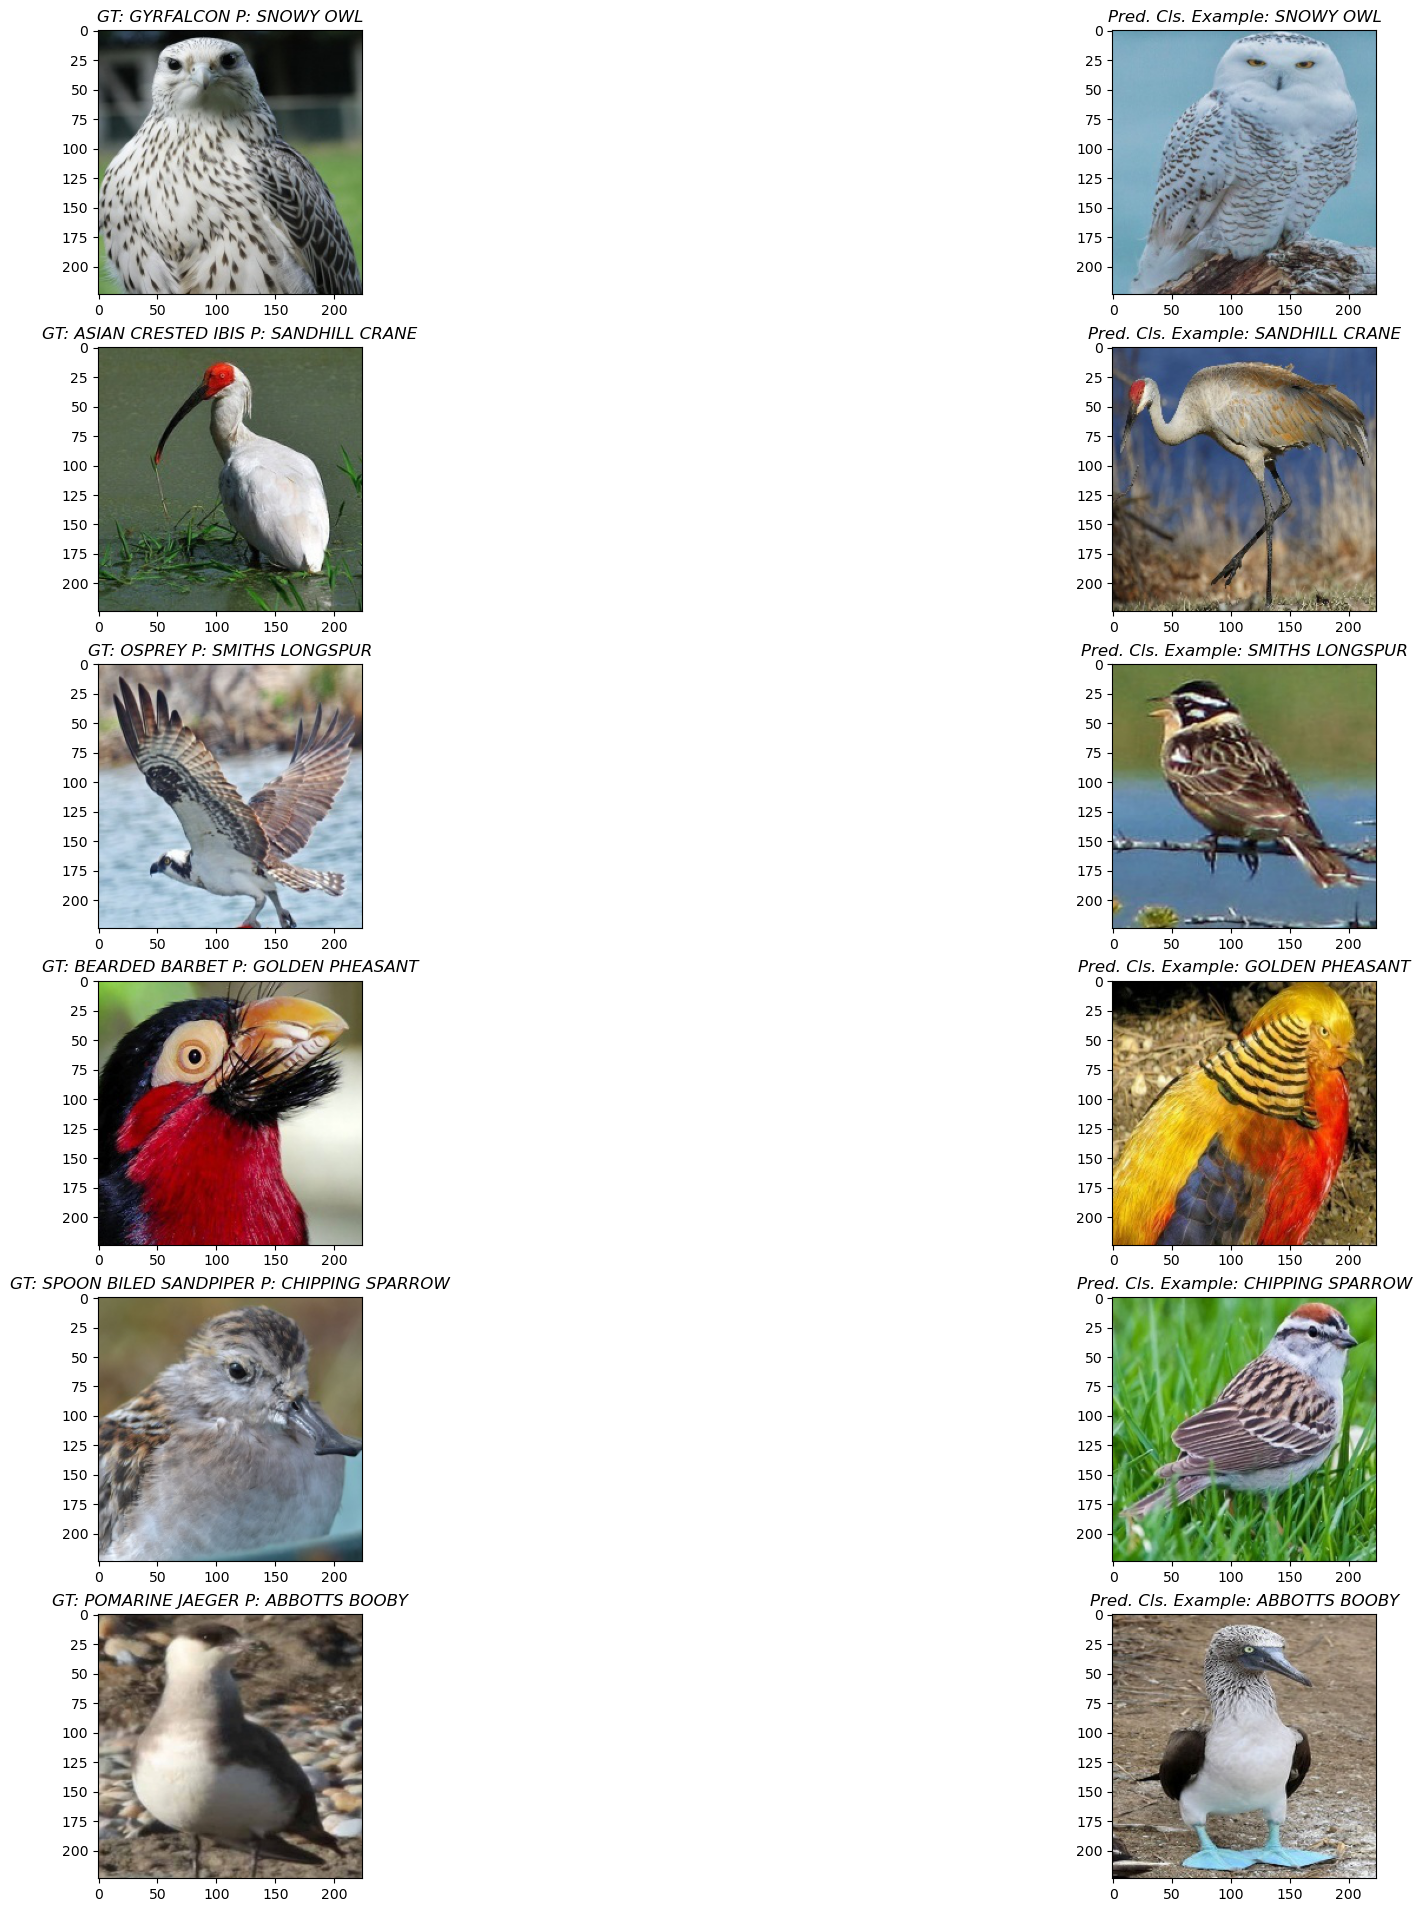

In [9]:
gt_array, pred_array, test_loss, test_acc = validate(net_sgd, testloader, nn.CrossEntropyLoss())
print(f"Test Accuracy: {test_acc} %")
print(f"Test Loss: {test_loss}")

# Displaying random misclassified images
fig=plt.figure(figsize=(24, 24))
columns = 2
rows = 6
mistake_indices = np.nonzero(gt_array != pred_array)[0]
for i in range(rows):
  chosen_index = mistake_indices[np.random.randint(len(mistake_indices))]
  input, label = testset[chosen_index]
  pred_label = pred_array[chosen_index].astype(np.int32)
  pred_cls_samples = np.nonzero(gt_array == pred_label)[0]
  pred_cls_input, _ = testset[pred_cls_samples[np.random.randint(len(pred_cls_samples))]]


  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+1)
  im_title = "GT: "+trainset.classes[label] + " P: "+trainset.classes[pred_label]
  ax.set_title(im_title, fontstyle='italic')
  plt.imshow(img)

  img_sample = pred_cls_input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+2)
  im_title = "Pred. Cls. Example: "+trainset.classes[pred_label]
  ax.set_title(im_title, fontstyle='italic')
  plt.imshow(img_sample)

plt.show()


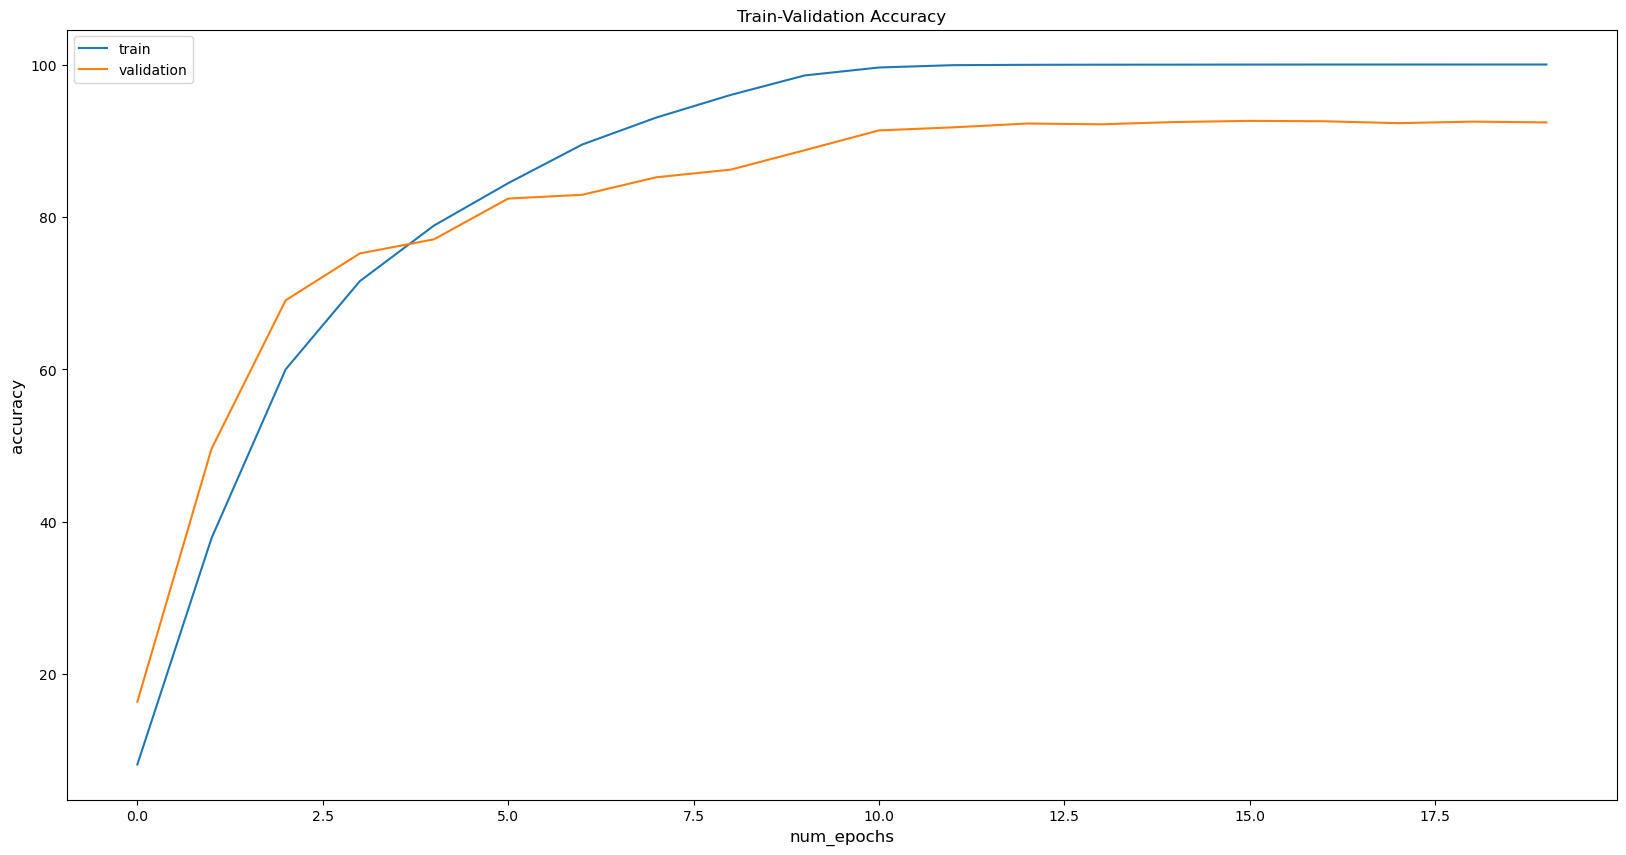

In [10]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc_sgd, label='train')
plt.plot(val_acc_sgd, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

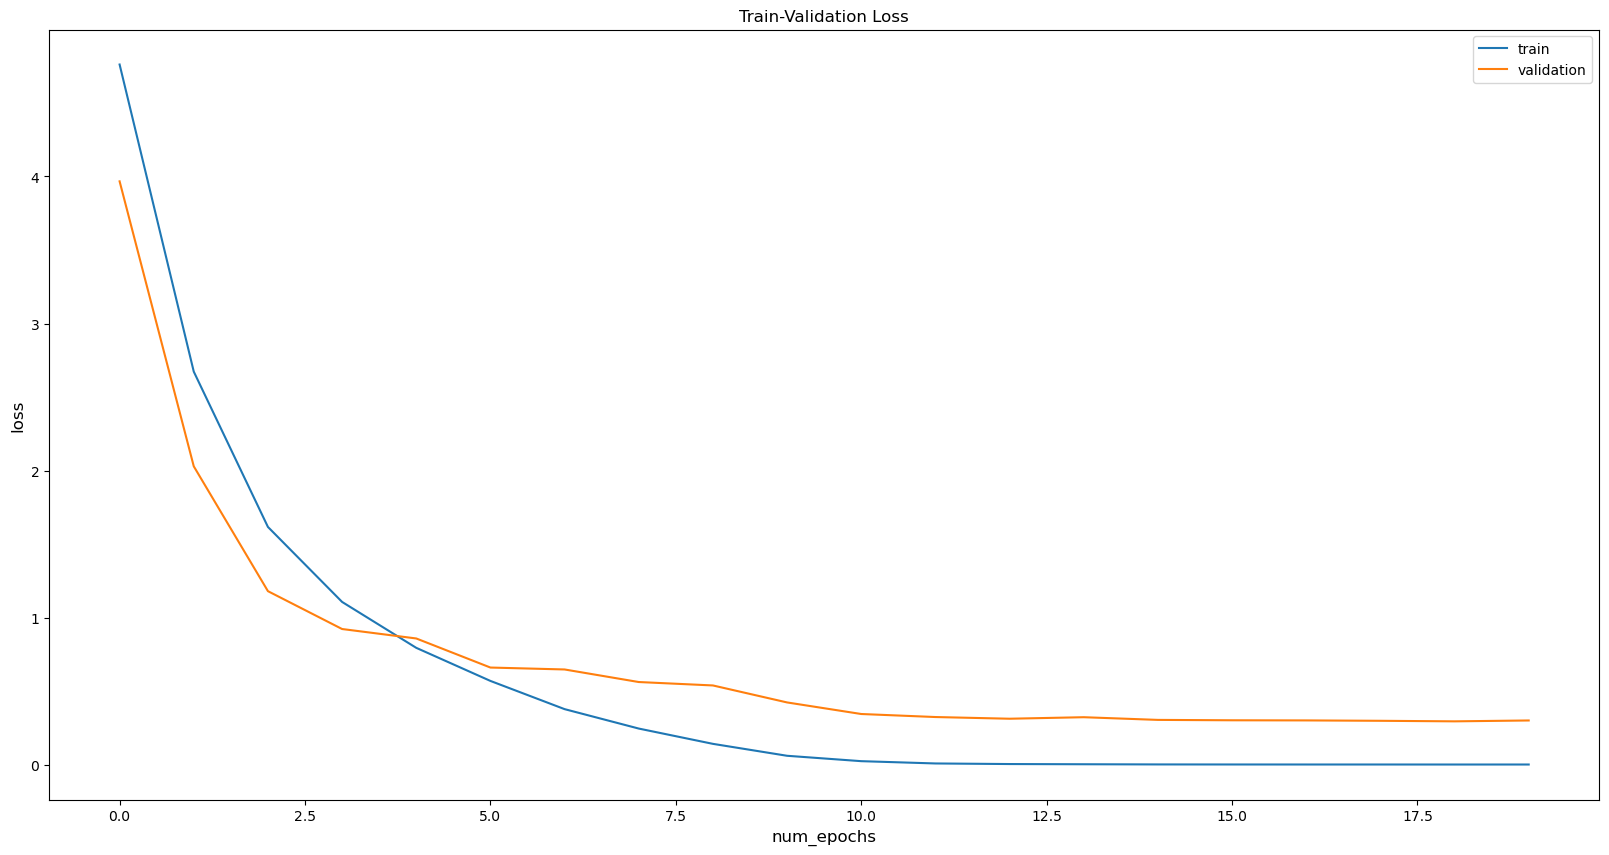

In [11]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss")
plt.plot(train_loss_sgd, label='train')
plt.plot(val_loss_sgd, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')